In [11]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt
import gdal

gdal.UseExceptions()

%matplotlib inline

# Set plot fonts to a larger size
plt.rcParams.update({'font.size': 12})

Set font sizes

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---
### MODIS LST:


Import pickled LST time series for Tuolumne:

In [3]:
modis1 = pd.read_pickle("../pkl/modis-tuolumne_2017_1-59.pkl")
modis2 = pd.read_pickle("../pkl/modis-tuolumne_2017_60-120.pkl")
modis = pd.concat([modis1, modis2]) # concatenate these two time series together

In [4]:
# take a look at the dataframe
modis.head()

,index,datetime,temperature,temp_min,temp_max,temp_mean
0,0,2017-01-01 00:35:00,NaN,-9.57,-9.45,-9.503333
1,1,2017-01-01 03:10:00,NaN,NaN,NaN,NaN
2,2,2017-01-01 04:50:00,-11.99,-12.17,-11.99,-12.080000
3,3,2017-01-01 12:35:00,-4.09,-4.99,-3.33,-4.130000
4,4,2017-01-01 14:15:00,NaN,-10.05,-0.99,-6.642500


Get rid of any rows with nan mean temperatures (this means all pixels in the 3x3 grid were nan):

In [5]:
modis = modis[~modis.temp_mean.isnull()]

In [6]:
# make sure those rows were dropped
modis.head()

,index,datetime,temperature,temp_min,temp_max,temp_mean
0,0,2017-01-01 00:35:00,NaN,-9.57,-9.45,-9.503333
2,2,2017-01-01 04:50:00,-11.99,-12.17,-11.99,-12.080000
3,3,2017-01-01 12:35:00,-4.09,-4.99,-3.33,-4.130000
4,4,2017-01-01 14:15:00,NaN,-10.05,-0.99,-6.642500
5,5,2017-01-01 15:55:00,NaN,-7.71,-6.65,-7.180000


### Gaylor Pit Tss:
Load Gaylor Pit snow surface temperature data

In [7]:
# Gaylor Pit surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GaylorPit\GaylorPit2017_039_T15min.csv'
gaylor = pd.read_csv(filepath)

# Make some data type and unit conversions
gaylor['datetime'] = pd.to_datetime(gaylor['TIMESTAMP']) # timestamp string to pandas datetime
gaylor['Judd_Air_TempC'] = (gaylor['Judd_Air_TempF'] - 32) / 1.8 # temperature F to temperature C
gaylor['Judd_Depth_cm'] = gaylor['Judd_Depth_in'] * 2.54 # snowdepth inches to snowdepth cm


### GOES-16 Tb:
Load GOES-16 brightness temperature timeseries:

In [8]:
g16_z1 = pd.read_pickle('../pkl/goes16-c14-Mar2017-gaylorpit.pkl') # w/ parallax correction
g16_z2 = pd.read_pickle('../pkl/goes16-c14-Apr2017-gaylorpit.pkl') # w/ parallax correction
g16_z = pd.concat([g16_z1, g16_z2]) # concatenate these two time series together

# Convert UTC time to local time (UTC-7)
g16_z['time_utc-7'] = g16_z.time - dt.timedelta(hours=7)
#g16['time_utc-7'] = g16.time - dt.timedelta(hours=7)
g16_z = g16_z.drop(columns='time')

***
## Plot a timeline of MODIS, GOES, and Gaylor Pit temperature data together

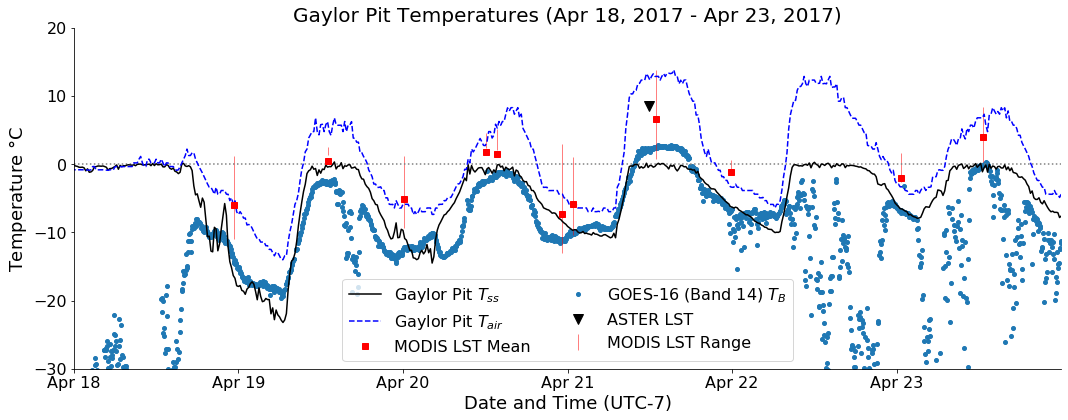

In [34]:
starttime = pd.to_datetime('2017-04-18 00:00')
endtime = pd.to_datetime('2017-04-23 23:59:59')

fig, ax = plt.subplots(figsize=(15,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')

modis.plot(x='datetime',y='temp_mean',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST Mean',alpha=1)

#g16.plot(x='time_utc-7',y='tb',
#         c='tab:grey', linestyle='--',ax=ax,
#         label='GOES-16 $T_B$*')

g16_z.plot(x='time_utc-7',y='tb',
         c='#1f78b4', linestyle='None',marker='o',
           markersize=4,ax=ax,zorder=0,
         label='GOES-16 (Band 14) $T_B$')


aster_time = pd.to_datetime('2017-04-21 11:51:07')
aster_LST = 8.55
plt.plot(aster_time,aster_LST,'v',color='k',markersize=10,label='ASTER LST')

plt.errorbar(modis.datetime,modis.temp_mean,
             yerr=[modis.temp_min,modis.temp_max],
             linestyle='None',c='r',linewidth=1,capsize=0,alpha=0.5,
             label='MODIS LST Range')


plt.subplots_adjust(right=1)
plt.legend(loc='lower center',ncol=2) #bbox_to_anchor=(0.0, -0.05)
ax.set_xlim((starttime,endtime))
ax.set_ylim((-30,20))
ax.set_ylabel('Temperature $\degree$C');

ax.set_xlabel('Date and Time (UTC-7)');
ymdhFmt = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(ymdhFmt)
plt.xticks(rotation=0, ha='center')
ax.xaxis.set_major_locator(mdates.DayLocator())

ax.set_title('Gaylor Pit Temperatures ({} - {})'.format(starttime.strftime("%b %d, %Y"),endtime.strftime("%b %d, %Y")));


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('../agu2019_poster_figures/GaylorPit-MODIS-ASTER-LST-timeline-April2017.png',dpi=300,bbox_inches='tight')

***
Function for finding times from two timeseries that are nearest each other:

In [35]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

### Compare GOES and MODIS
First, find all the GOES observations closest in time to the MODIS observations.

In [36]:
## Compute the difference in temperatures (MODIS - GOES)
#delta = []
#goes_tb = []
#modis_t = []
#modis_tmean = []
#modis_tmin = []
#modis_tmax = []
#
#times = modis['datetime'][(modis['datetime'] >= g16_z['time_utc-7'].min()) & (modis['datetime'] <= g16_z['time_utc-7'].max())]

In [37]:
#i = 0
#for t in times:
#    goes_time = nearest(g16_z['time_utc-7'],t)
#
#    #print('MODIS Time:{} \t GOES Time:{}'.format(t,goes_time))
#    
#    tb = g16_z.tb[g16_z['time_utc-7'] == goes_time].values[0]
#    goes_tb.append(tb)
#    
#    _modis_tmean = modis.temp_mean[modis['datetime']==t].values[0]
#    _modis_tmin = modis.temp_min[modis['datetime']==t].values[0]
#    _modis_tmax = modis.temp_max[modis['datetime']==t].values[0]
#    modis_tmean.append(_modis_tmean)
#    modis_tmin.append(_modis_tmin)
#    modis_tmax.append(_modis_tmax)
#    #print('{} \t {} \t {}'.format(_modis_tmin,_modis_tmean,_modis_tmax))
#    delta.append(_modis_tmean - goes_tb[i])
#
#    i+=1

Save this data out to a file

In [38]:
## make a dict with all the data
#d = {'datetime': times, 
#     'modis_tmean': modis_tmean, 
#     'modis_tmin': modis_tmin,
#     'modis_tmax': modis_tmax,
#     'modis_trange': np.array(modis_tmax)-np.array(modis_tmin),
#     'goes_tb': goes_tb,
#     'delta': delta,
#     }
## make the dict a pandas dataframe
#goes_vs_modis = pd.DataFrame(data=d)
#
## Export this the dataframe to a pickle file
#goes_vs_modis.to_pickle("../pkl/goes_vs_modis_2017_Mar-Apr.pkl", protocol=3)

Read pickle file

In [39]:
goes_vs_modis = pd.read_pickle("../pkl/goes_vs_modis_2017_Mar-Apr.pkl")
goes_vs_modis.head()

,datetime,modis_tmean,modis_tmin,modis_tmax,modis_trange,goes_tb,delta
0,2017-03-01 00:15:00,-15.805556,-17.89,-15.09,2.80,-16.230835,0.425279
1,2017-03-01 12:20:00,-0.157500,-1.67,0.63,2.30,1.862030,-2.019530
2,2017-03-01 23:20:00,-12.076667,-16.21,-10.01,6.20,-11.772705,-0.303962
3,2017-03-02 13:00:00,2.138889,1.53,2.91,1.38,4.673676,-2.534787
4,2017-03-03 00:05:00,-10.234444,-11.85,-9.69,2.16,-10.941132,0.706687


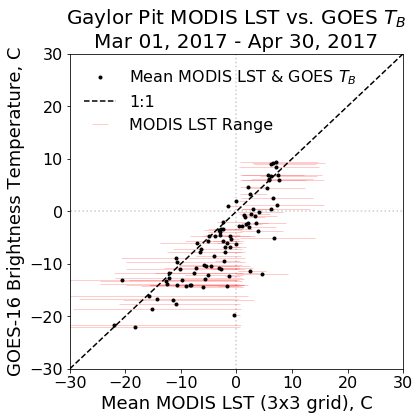

In [51]:
#modis_t =  modis['temperature'][(modis['datetime'] >= g16_z['time_utc-7'].min()) & (modis['datetime'] <= g16_z['time_utc-7'].max())]

f, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(goes_vs_modis.modis_tmean,goes_vs_modis.goes_tb,'.k',label='Mean MODIS LST & GOES $T_B$')
ax.errorbar(goes_vs_modis.modis_tmean,goes_vs_modis.goes_tb,fmt='none',
            yerr=None,xerr=[goes_vs_modis.modis_tmin,goes_vs_modis.modis_tmax],
            ecolor='r', elinewidth=0.5, capsize=0,alpha=0.4,
            label='MODIS LST Range')
ax.plot([-30,30],[-30,30],'--',c='k',label='1:1',alpha=1)
ax.plot([0,0],[-100,100],':',c='k',alpha=0.2)
ax.plot([-100,100],[0,0],':',c='k',alpha=0.2)
ax.set_xlabel('Mean MODIS LST (3x3 grid), C')
ax.set_ylabel('GOES-16 Brightness Temperature, C')
ax.set_xlim((-30,30))
ax.set_ylim((-30,30))
ax.set_title('Gaylor Pit MODIS LST vs. GOES $T_B$\n{} - {}'.format(goes_vs_modis.datetime.min().strftime("%b %d, %Y"),goes_vs_modis.datetime.max().strftime("%b %d, %Y")))
ax.legend(frameon=False,loc='upper left')
#ax.text(7,-29,'GOES-16 colder')
#ax.text(-29,17,'GOES-16 warmer')


plt.tight_layout()
plt.savefig('../agu2019_poster_figures/MODIS-tmean-vs-GOES-16-LST-Mar-April2017.png',dpi=300,bbox_inches='tight')

In [41]:
print('Mean bais: {} C'.format(np.round(np.nanmean(goes_vs_modis.delta),2)))

Mean bais: 3.29 C


In [42]:
#plt.figure(figsize=(7,5))
#
#plt.plot(pd.DatetimeIndex(times).hour,delta,'ok',label='$\Delta T$',alpha=1);
#
#plt.xlabel('Hour of Day')
#plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
##plt.legend()
#plt.plot([0, 24],[0, 0],':',c='tab:grey')
#plt.title('Temperature Difference and Hour of Day\n(MODIS - GOES-16)');
#
#plt.savefig('MODIS-GOES-16-deltaLST-hour-of-day-April2017.png',dpi=300)

In [43]:
#plt.figure(figsize=(7,5))
#modis_viewangle = modis['viewangle'][(modis['datetime'] >= g16_z['time_utc-7'].min()) & (modis['datetime'] <= g16_z['time_utc-7'].max())]
#plt.plot(modis_viewangle,delta,'ok',label='$\Delta T$',alpha=1);
#
#plt.xlabel('View Angle from Nadir')
#plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
##plt.legend()
#plt.xlim([0,70])
#plt.plot([0, 70],[0, 0],'-',c='tab:grey')
#plt.title('Temperature Difference and View Angle\n(MODIS - GOES-16)');
#
#plt.savefig('MODIS-GOES-16-deltaLST-view-angle-April2017.png',dpi=300)

***
### Compare GOES and Gaylor Pit

First, find the GOES observations closest in time to the Gaylor Pit data (GOES-16 was sampling at 5 minute intervals, Gaylor Pit in situ data is at 15 minute intervals).

In [44]:
## Compute the difference in temperatures (GOES - Gaylor Pit)
#delta_tair = []
#delta_tsnow = []
#gaylor_tair = []
#gaylor_tsnow = []
#goes_tb = []
#
#times = (gaylor.datetime > np.min(g16_z['time_utc-7'])) & (gaylor.datetime < np.max(g16_z['time_utc-7']))

In [45]:
#for t in gaylor.datetime[times]:
#    print(t)
#    goes_time = (nearest(g16_z['time_utc-7'],t))
#    tb = g16_z.tb[g16_z['time_utc-7'] == goes_time].values[0]
#    goes_tb.append(tb)
#    
#    tsnow = gaylor['TT_C'][gaylor['datetime']==t].values[0]
#    gaylor_tsnow.append(tsnow)
#    tair = gaylor['Judd_Air_TempC'][gaylor['datetime']==t].values[0]
#    gaylor_tair.append(tair)
#    
#    delta_tsnow.append(tb - tsnow)
#    delta_tair.append(tb - tair)
    

Pickle this data out to a file:

In [46]:
## make a dict with all the data
#d = {'datetime': gaylor.datetime[times], 
#     'goes_tb': goes_tb, 
#     'gaylor_tair': gaylor_tair,
#     'gaylor_tsnow': gaylor_tsnow,
#     'delta_tair': delta_tair,
#     'delta_tsnow': delta_tsnow
#     }
## make the dict a pandas dataframe
#goes_vs_insitu = pd.DataFrame(data=d)
#
#
#goes_vs_insitu
#
## Export this the dataframe to a pickle file
#goes_vs_insitu.to_pickle("../pkl/goes16_vs_gaylorpit_2017_Mar_Apr.pkl", protocol=3)

Read the pickle file if we've already written it:

In [47]:
goes_vs_insitu = pd.read_pickle("../pkl/goes16_vs_gaylorpit_2017_Mar_Apr.pkl")
goes_vs_insitu.head()

,datetime,goes_tb,gaylor_tair,gaylor_tsnow,delta_tair,delta_tsnow
49757,2017-02-28 17:15:00,-6.383118,-2.288889,-8.43,-4.094229,2.046882
49758,2017-02-28 17:30:00,-6.698395,-2.700000,-8.59,-3.998395,1.891605
49759,2017-02-28 17:45:00,-7.292450,-3.238889,-9.96,-4.053561,2.667550
49760,2017-02-28 18:00:00,-7.650726,-3.783333,-11.49,-3.867393,3.839274
49761,2017-02-28 18:15:00,-8.492279,-5.266667,-13.84,-3.225612,5.347721


#### Compare GOES-16 Brightness Temperature with in situ snow and air temperatures:

Mean Tsnow bais: -6.52 C
Mean Tair bais: -11.68 C
Median Tsnow bais: -2.77 C
Median Tair bais: -7.95 C
Tsnow RMS error: 14.91 C
Tair RMS error: 16.64 C
Tsnow r2: 0.005004152170921743 C
Tair r2: 0.1189958475764253 C


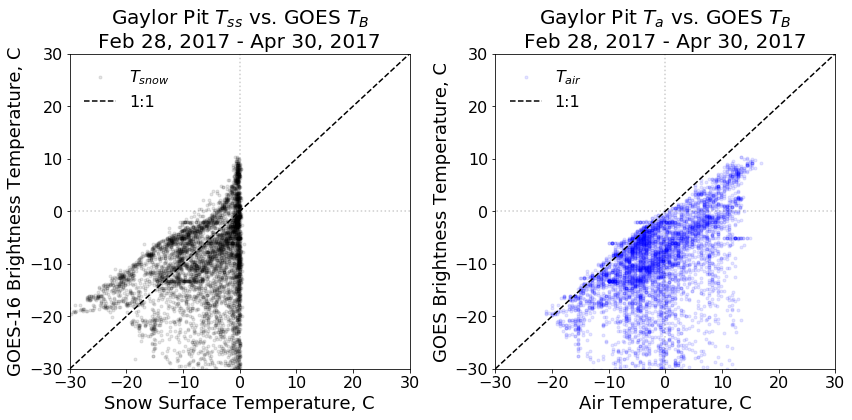

In [48]:
f, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(goes_vs_insitu.gaylor_tsnow,goes_vs_insitu.goes_tb,'.k',label='$T_{snow}$',alpha=0.1)
ax[0].plot([-30,30],[-30,30],'--',c='k',label='1:1')
ax[0].plot([0,0],[-100,100],':',c='k',alpha=0.2)
ax[0].plot([-100,100],[0,0],':',c='k',alpha=0.2)
ax[0].set_xlabel('Snow Surface Temperature, C')
ax[0].set_ylabel('GOES-16 Brightness Temperature, C')
ax[0].set_xlim((-30,30))
ax[0].set_ylim((-30,30))
ax[0].set_title('Gaylor Pit $T_{{ss}}$ vs. GOES $T_B$\n{} - {}'.format(goes_vs_insitu.datetime.min().strftime("%b %d, %Y"),goes_vs_insitu.datetime.max().strftime("%b %d, %Y")))
ax[0].legend(loc='upper left',frameon=False)
#ax[0].text(7,-29,'GOES-16 colder')
#ax[0].text(-29,17,'GOES-16 warmer')

ax[1].plot(goes_vs_insitu.gaylor_tair,goes_vs_insitu.goes_tb,'.b',label='$T_{air}$',alpha=0.1)
ax[1].plot([-30,30],[-30,30],'--',c='k',label='1:1')
ax[1].plot([0,0],[-100,100],':',c='k',alpha=0.2)
ax[1].plot([-100,100],[0,0],':',c='k',alpha=0.2)
ax[1].set_xlabel('Air Temperature, C')
ax[1].set_ylabel('GOES Brightness Temperature, C')
ax[1].set_xlim((-30,30))
ax[1].set_ylim((-30,30))
ax[1].set_title('Gaylor Pit $T_{{a}}$ vs. GOES $T_B$\n{} - {}'.format(goes_vs_insitu.datetime.min().strftime("%b %d, %Y"),goes_vs_insitu.datetime.max().strftime("%b %d, %Y")))
ax[1].legend(loc='upper left',frameon=False)
#ax[1].text(7,-29,'GOES-16 colder')
#ax[1].text(-29,17,'GOES-16 warmer')
plt.tight_layout()
plt.savefig('../agu2019_poster_figures/GaylorPit-vs-GOES-16-LST-Mar-April2017.png',dpi=300,bbox_inches='tight')

print('Mean Tsnow bais: {} C'.format(np.round(np.nanmean(goes_vs_insitu.delta_tsnow),2)))
print('Mean Tair bais: {} C'.format(np.round(np.nanmean(goes_vs_insitu.delta_tair),2)))

print('Median Tsnow bais: {} C'.format(np.round(np.nanmedian(goes_vs_insitu.delta_tsnow),2)))
print('Median Tair bais: {} C'.format(np.round(np.nanmedian(goes_vs_insitu.delta_tair),2)))

print('Tsnow RMS error: {} C'.format(np.round( np.sqrt(np.nanmean(goes_vs_insitu.delta_tsnow**2)),2)))
print('Tair RMS error: {} C'.format(np.round( np.sqrt(np.nanmean(goes_vs_insitu.delta_tair**2)),2)))


print('Tsnow r2: {} C'.format((goes_vs_insitu.corr().goes_tb.gaylor_tsnow**2)))
print('Tair r2: {} C'.format((goes_vs_insitu.corr().goes_tb.gaylor_tair**2)))

In [49]:
## Try this as a heatmap plot
#nbins=50
#
## ignore nan values
#x = goes_vs_insitu.gaylor_tsnow
#y = goes_vs_insitu.goes_tb
#bad_indices = (np.isnan(x) | np.isnan(y))
#good_indices = ~bad_indices
#good_x = x[good_indices]
#good_y = y[good_indices]
#
#
#f, ax = plt.subplots(1,2,figsize=(12,6))
##ax[0].plot(goes_vs_insitu.gaylor_tsnow,goes_vs_insitu.goes_tb,'.k',label='Tsnow',alpha=0.1)
#H, xedges, yedges = np.histogram2d(good_x,good_y, bins=nbins)
#X, Y = np.meshgrid(xedges, yedges)
#ax[0].pcolormesh(X,Y,H,cmap=plt.cm.Greys)
#ax[0].plot([-30,30],[-30,30],'--',c='k',label='1:1')
#ax[0].plot([0,0],[-100,100],':',c='k',alpha=0.2)
#ax[0].plot([-100,100],[0,0],':',c='k',alpha=0.2)
#ax[0].set_xlabel('Gaylor Pit Snow Temperature, C')
#ax[0].set_ylabel('GOES-16 Brightness Temperature, C')
#ax[0].set_xlim((-30,30))
#ax[0].set_ylim((-30,30))
#ax[0].set_title('{} - {}'.format(goes_vs_insitu.datetime.min().strftime("%B %d, %Y"),goes_vs_insitu.datetime.max().strftime("%B %d, %Y")))
#ax[0].legend()
##ax[0].text(7,-29,'GOES-16 colder')
##ax[0].text(-29,17,'GOES-16 warmer')
#
#
## ignore nan values
#x = goes_vs_insitu.gaylor_tair
#y = goes_vs_insitu.goes_tb
#bad_indices = np.isnan(x) | np.isnan(y)
#good_indices = ~bad_indices
#good_x = x[good_indices]
#good_y = y[good_indices]
#
##ax[1].plot(goes_vs_insitu.gaylor_tair,goes_vs_insitu.goes_tb,'.b',label='Tair',alpha=0.1)
#H, xedges, yedges = np.histogram2d(good_x,good_y, bins=nbins)
#X, Y = np.meshgrid(xedges, yedges)
#ax[1].pcolormesh(X,Y,H,cmap=plt.cm.Blues)
#ax[1].plot([-30,30],[-30,30],'--',c='k',label='1:1')
#ax[1].plot([0,0],[-100,100],':',c='k',alpha=0.2)
#ax[1].plot([-100,100],[0,0],':',c='k',alpha=0.2)
#ax[1].set_xlabel('Gaylor Pit Air Temperature, C')
#ax[1].set_ylabel('GOES Brightness Temperature, C')
#ax[1].set_xlim((-30,30))
#ax[1].set_ylim((-30,30))
#ax[1].set_title('{} - {}'.format(goes_vs_insitu.datetime.min().strftime("%B %d, %Y"),goes_vs_insitu.datetime.max().strftime("%B %d, %Y")))
#ax[1].legend()
##ax[1].text(7,-29,'GOES-16 colder')
##ax[1].text(-29,17,'GOES-16 warmer')
#
#plt.savefig('../agu2019_poster_figures/GaylorPit-vs-GOES-16-LST-Mar-April2017_heatmap.png',dpi=300)
#
#print('Mean bais: {} C'.format(np.round(np.nanmean(goes_vs_insitu.delta_tsnow),2)))
#print('Mean bais: {} C'.format(np.round(np.nanmean(goes_vs_insitu.delta_tair),2)))

#### How does the difference between GOES-16 Brightness Temperature and ground data change as a function of time?

In [449]:
#plt.figure(figsize=(15,5))
#plt.plot(gaylor.datetime[times],delta_tair,'.',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
#plt.plot(gaylor.datetime[times],delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);
#
#plt.xlabel('Time')
#plt.ylabel('$\Delta Temperature \,\, \degree C$\n GOES-16 Colder <------> GOES-16 Warmer')
#plt.legend()
#plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
#plt.title('Temperature Difference and Over Time\n(GOES-16 - Gaylor Pit) {}-{}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")));
#plt.savefig('GaylorPit-GOES-16-deltaLST-timeline-April2017.png',dpi=300)

#### How does the difference between GOES-16 Tb and ground data change as a function of hour of day?

In [450]:
#f, ax = plt.subplots(1,2,figsize=(14,5))
#
#ax[0].plot(pd.DatetimeIndex(gaylor.datetime[times]).hour,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);
#ax[0].set_xlabel('Hour of Day')
#ax[0].set_ylabel('$\Delta Temperature \,\, \degree C$\n GOES-16 Colder <------> GOES-16 Warmer')
#ax[0].legend()
#ax[0].plot([0, 24],[0, 0],':',c='tab:grey')
#ax[0].set_title('Temperature Difference and Hour of Day\n(GOES-16 - Gaylor Pit)');
#
#ax[1].plot(pd.DatetimeIndex(gaylor.datetime[times]).hour,delta_tair,'.',markeredgecolor='b',markerfacecolor='b',label='$\Delta T_{air}$',alpha=1);
#ax[1].set_xlabel('Hour of Day')
#ax[1].set_ylabel('$\Delta Temperature \,\, \degree C$\n GOES-16 Colder <------> GOES-16 Warmer')
#ax[1].legend()
#ax[1].plot([0, 24],[0, 0],':',c='tab:grey')
#ax[1].set_title('Temperature Difference and Hour of Day\n(GOES-16 - Gaylor Pit)');
#
#
#plt.savefig('GaylorPit-GOES-16-deltaLST-hour-of-day-April2017.png',dpi=300)

***
### Compare MODIS and Gaylor Pit


Find the Gaylor Pit observations closest in time to our MODIS data, compute the difference between MODIS LST and Gaylor Pit Tsnow and Tair
Then plot MODIS LST vs Gaylor Pit Tsnow and Tair to see how they compare...

In [451]:
## Compute the difference in temperatures (MODIS - Gaylor Pit)
#delta_tair = []
#delta_tsnow = []
#gaylor_tair = []
#gaylor_tsnow = []
#
#i = 0
#for time in modis['datetime']:
#    gaylor_time = (nearest(gaylor['datetime'],time))
#    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
#    gaylor_tsnow.append(gaylor['TT_C'][gaylor['datetime']==gaylor_time].values[0])
#    gaylor_tair.append(gaylor['Judd_Air_TempC'][gaylor['datetime']==gaylor_time].values[0])
#    modis_t = modis.temperature[modis['datetime']==time].values[0]
#    #modis_tmean = modis.temp_mean[modis['datetime']==time].values[0]
#    #modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
#    #modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
#    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
#    delta_tsnow.append(modis_t - gaylor_tsnow[i])
#    delta_tair.append(modis_t - gaylor_tair[i])
#    i+=1
#

Pickle this data out to a file:

In [95]:
## make a dict with all the data
#d = {'datetime': modis.datetime, 
#     'modis_temp': modis.temperature, 
#     'gaylor_tair': gaylor_tair,
#     'gaylor_tsnow': gaylor_tsnow,
#     'delta_tair': delta_tair,
#     'delta_tsnow': delta_tsnow
#     }
## make the dict a pandas dataframe
#modis_vs_insitu = pd.DataFrame(data=d)
#
#
#modis_vs_insitu
#
## Export this the dataframe to a pickle file
#modis_vs_insitu.to_pickle("../pkl/modis_vs_gaylorpit_2017_1-120.pkl", protocol=3)

Read in the pickle file if we've saved it out already

In [313]:
#modis_vs_insitu = pd.read_pickle("../pkl/modis_vs_gaylorpit_2017_1-120.pkl")

In [314]:
#modis_vs_insitu.head()

,datetime,modis_temp,gaylor_tair,gaylor_tsnow,delta_tair,delta_tsnow
0,2017-01-01 00:35:00,NaN,-11.016667,-20.120,NaN,NaN
2,2017-01-01 04:50:00,-11.99,-13.409444,-23.000,1.419444,11.010
3,2017-01-01 12:35:00,-4.09,3.222222,-6.462,-7.312222,2.372
4,2017-01-01 14:15:00,NaN,0.183333,-7.009,NaN,NaN
5,2017-01-01 15:55:00,NaN,-1.416667,-10.090,NaN,NaN


#### Compare MODIS LST with in situ snow and air temperatures:

In [452]:
#starttime = pd.to_datetime('2017-01-01 00:00')
#endtime = pd.to_datetime('2017-04-30 23:59:59')
#
#f, ax = plt.subplots(1,2,figsize=(12,6))
#ax[0].plot(modis_vs_insitu.gaylor_tsnow,modis_vs_insitu.modis_temp,'ok',label='Tsnow')
#ax[0].plot([-30,30],[-30,30],'--',c='k',label='1:1')
#ax[0].plot([0,0],[-100,100],':',c='k',alpha=0.2)
#ax[0].plot([-100,100],[0,0],':',c='k',alpha=0.2)
#ax[0].set_xlabel('Gaylor Pit Snow Temperature, C')
#ax[0].set_ylabel('MODIS LST, C')
#ax[0].set_xlim((-30,30))
#ax[0].set_ylim((-30,30))
#ax[0].set_title('{} - {}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")))
#ax[0].legend()
##ax[0].text(7,-29,'MODIS colder')
##ax[0].text(-29,17,'MODIS warmer')
#
#ax[1].plot(modis_vs_insitu.gaylor_tair,modis_vs_insitu.modis_temp,'o',markeredgecolor='b',markerfacecolor='None',label='Tair')
#ax[1].plot([-30,30],[-30,30],'--',c='k',label='1:1')
#ax[1].plot([0,0],[-100,100],':',c='k',alpha=0.2)
#ax[1].plot([-100,100],[0,0],':',c='k',alpha=0.2)
#ax[1].set_xlabel('Gaylor Pit Air Temperature, C')
#ax[1].set_ylabel('MODIS LST, C')
#ax[1].set_xlim((-30,30))
#ax[1].set_ylim((-30,30))
#ax[1].set_title('{} - {}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")))
#ax[1].legend()
##ax[1].text(7,-29,'MODIS colder')
##ax[1].text(-29,17,'MODIS warmer')
#
#plt.savefig('../agu2019_poster_figures/GaylorPit-vs-MODIS-LST_2017_1-120.png',dpi=300)

#### How does the difference between MODIS LST and ground data change as a function of time?

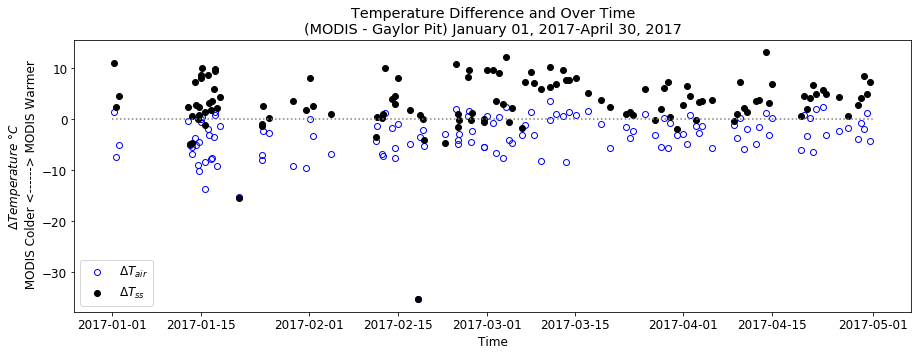

In [101]:
#plt.figure(figsize=(15,5))
#plt.plot(modis.datetime,delta_tair,'o',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
#plt.plot(modis.datetime,delta_tsnow,'ok',label='$\Delta T_{ss}$',alpha=1);
#
#plt.xlabel('Time')
#plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
#plt.legend()
#plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
#plt.title('Temperature Difference and Over Time\n(MODIS - Gaylor Pit) {}-{}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")));
#plt.savefig('../figures/GaylorPit-MODIS-deltaLST-timeline_2017_1-120.png',dpi=300)

#### How does the difference between MODIS LST and ground data change as a function of hour of day?

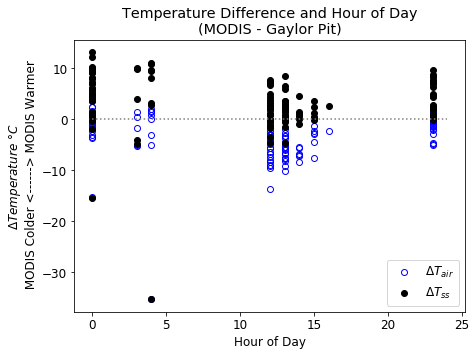

In [102]:
#plt.figure(figsize=(7,5))
#
#plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tair,'o',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
#plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tsnow,'ok',label='$\Delta T_{ss}$',alpha=1);
#
#plt.xlabel('Hour of Day')
#plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
#plt.legend()
#plt.plot([0, 24],[0, 0],':',c='tab:grey')
#plt.title('Temperature Difference and Hour of Day\n(MODIS - Gaylor Pit)');
#
#plt.savefig('GaylorPit-MODIS-deltaLST-hour-of-day_2017-1-120.png',dpi=300)

#### How does the difference between MODIS LST and ground data change as a function of view angle?

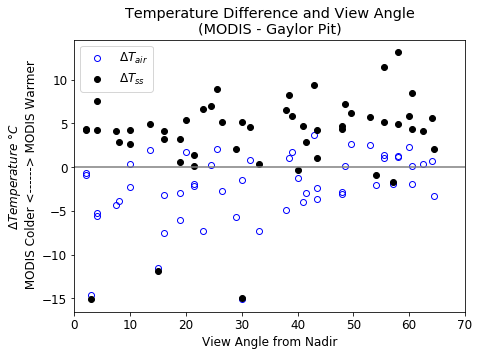

In [71]:
#plt.figure(figsize=(7,5))
#
#plt.plot(modis.viewangle,delta_tair,'o',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
#plt.plot(modis['viewangle'],delta_tsnow,'ok',label='$\Delta T_{ss}$',alpha=1);
#
#plt.xlabel('View Angle from Nadir')
#plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
#plt.legend()
#plt.xlim([0,70])
#plt.plot([0, 70],[0, 0],'-',c='tab:grey')
#plt.title('Temperature Difference and View Angle\n(MODIS - Gaylor Pit)');
#
#plt.savefig('GaylorPit-MODIS-deltaLST-view-angle.png',dpi=300)

***
work in progress below
***

If we assume a weighted mean between tforest (guessing that it can be represented here by tair) and tsnow, figure out what those weights are here.

In other words:

MODIS LST = ( (1-n) * Tforest + n * Tsnow )

where 1-n is the forest fraction of the pixel, and n is the snow fraction of the pixel

Therefore solving for n:

n = (MODIS LST - Tforest) / (Tsnow - Tforest)

In [ ]:
#snow_fraction = []
#for i in range(0,len(modis.temperature)):
#    snow_fraction.append(( modis.temperature[i] - gaylor_tair[i] ) / (gaylor_tsnow[i] - gaylor_tair[i]))
#

In [ ]:
#plt.plot(modis['viewangle'],snow_fraction,'.k');
#plt.xlabel('View Angle from Nadir')
#plt.ylabel('Estimated Visible Snow Fraction')
#plt.xlim([0,70])
#plt.ylim([-1,1])
#plt.plot([0, 70],[0, 0],'-',c='tab:grey')
#plt.title('Estimated Visible Snow Fraction and View Angle');

# Where snow fraction is < 0, MODIS LST is higher than Tair

#plt.savefig('GaylorPit-MODIS-fsca-test.png',dpi=300)

What's the spread between Tsnow and Tair over time?

In [ ]:
#starttime = pd.to_datetime('2017-04-09 00:00')
#endtime = pd.to_datetime('2017-04-30 23:59:59')
#
#fig, ax = plt.subplots(figsize=(20,6))
#
#plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
#
#plt.plot(gaylor.datetime,gaylor.Judd_Air_TempC-gaylor.TT_C, color='r', label= 'Gaylor Pit $T_{air}$ - $T_{ss}$')
#gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
#gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
#modis.plot(x='datetime',y='temperature',
#           marker='s',c='r',linestyle='None',ax=ax,
#           label='MODIS LST',alpha=0.5)
#plt.legend()
#ax.set_xlim((starttime,endtime))
#ax.set_ylim((-40,20))
#ax.set_ylabel('Temperature $\degree$C');
#ax.set_title('Gaylor Pit Air-Snow Surface Temperatures');
#plt.savefig('Gaylor Pit Air-Snow Surface Temperatures.png',dpi=300)